# Working with a result file {#ref_basic_load_file_example}

This example shows how to write and upload files on the server machine
and then download them back on the client side. The resulting fields
container is then exported to a CSV file.


Load a model from the DPF-Core examples: `ansys.dpf.core` module.


In [1]:
from ansys.dpf import core as dpf
from ansys.dpf.core import examples


model = dpf.Model(examples.find_simple_bar())
mesh = model.metadata.meshed_region

# Get and plot the fields container for the result

Get the fields container for the result and plot it so you can compare
it later:


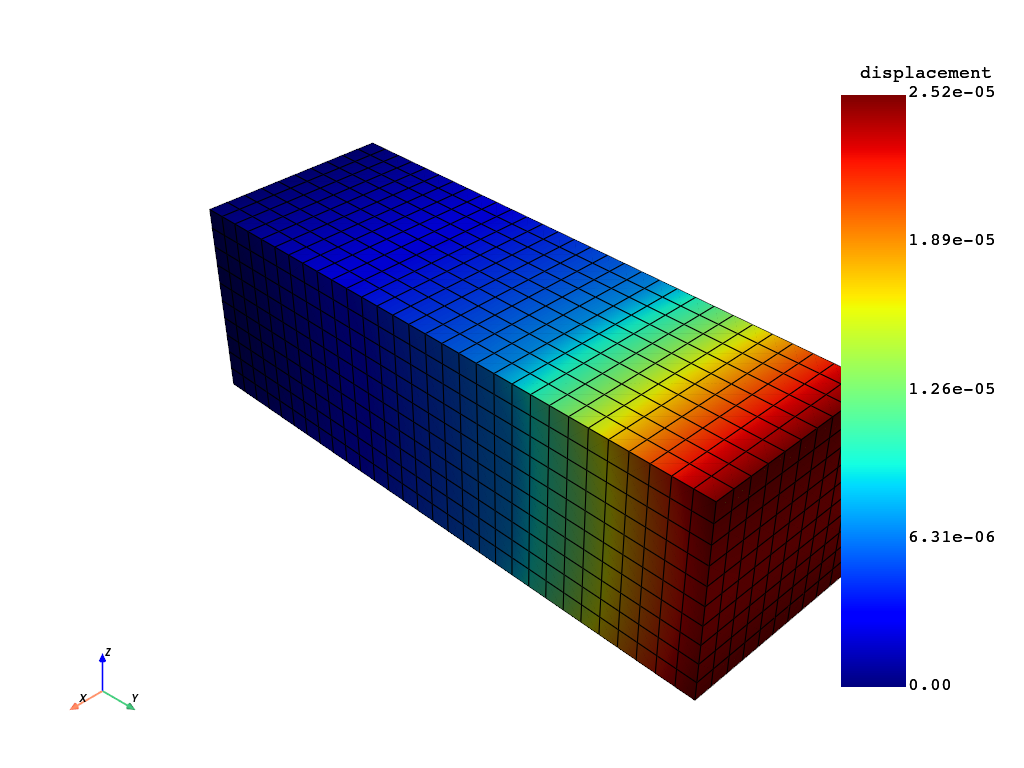

In [2]:
displacement_operator = model.results.displacement()
fc_out = displacement_operator.outputs.fields_container()
mesh.plot(fc_out)

# Export result

Export the fields container in the CSV format:


In [3]:
import os

csv_file_name = "simple_bar_fc.csv"
# Define an output path for the resulting .csv file
if not dpf.SERVER.local_server:
    # Define it server-side if using a remote server
    tmp_dir_path = dpf.core.make_tmp_dir_server(dpf.SERVER)
    server_file_path = dpf.path_utilities.join(tmp_dir_path, csv_file_name)
else:
    server_file_path = os.path.join(os.getcwd(), csv_file_name)

# Perform the export to csv on the server side
export_csv_operator = dpf.operators.serialization.field_to_csv()
export_csv_operator.inputs.field_or_fields_container.connect(fc_out)
export_csv_operator.inputs.file_path.connect(server_file_path)
export_csv_operator.run()

# Download CSV result file

Download the file `simple_bar_fc.csv`:


In [4]:
if not dpf.SERVER.local_server:
    downloaded_client_file_path = os.path.join(os.getcwd(), "simple_bar_fc_downloaded.csv")
    dpf.download_file(server_file_path, downloaded_client_file_path)
else:
    downloaded_client_file_path = server_file_path

# Load CSV result file as operator input

Load the fields container contained in the CSV file as an operator
input:


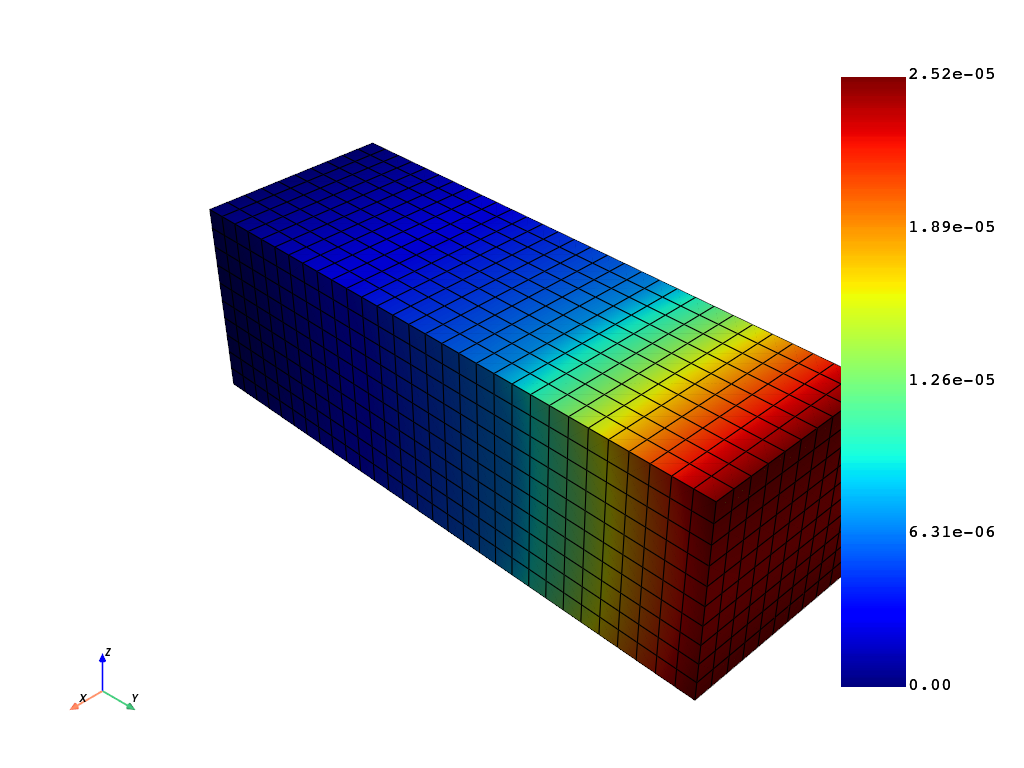

In [5]:
my_data_sources = dpf.DataSources(server_file_path)
import_csv_operator = dpf.operators.serialization.csv_to_field()
import_csv_operator.inputs.data_sources.connect(my_data_sources)
server_fc_out = import_csv_operator.outputs.fields_container()
mesh.plot(server_fc_out)

# Remove file to avoid polluting.
os.remove(downloaded_client_file_path)

# Make operations over the fields container

Use this fields container to get the minimum displacement:


In [6]:
min_max_op = dpf.operators.min_max.min_max_fc()
min_max_op.inputs.fields_container.connect(server_fc_out)
min_field = min_max_op.outputs.field_min()
min_field.data

DPFArray([[-8.202171e-07, -6.265107e-06, -2.444680e-05]])

# Compare the original and the new fields container

Subtract the two fields and plot an error map:


In [7]:
abs_error = (fc_out - server_fc_out).eval()

divide = dpf.operators.math.component_wise_divide()
divide.inputs.fieldA.connect(fc_out - server_fc_out)
divide.inputs.fieldB.connect(fc_out)
scale = dpf.operators.math.scale()
scale.inputs.field.connect(divide)
scale.inputs.ponderation.connect(100.0)
rel_error = scale.eval()

# Plot both absolute and relative error fields

Note that the absolute error is bigger where the displacements are
bigger, at the tip of the geometry. Instead, the relative error is
similar across the geometry since we are dividing by the displacements
`fc_out`. Both plots show errors that can be understood as zero due to
machine precision (1e-12 mm for the absolute error and 1e-5% for the
relative error).


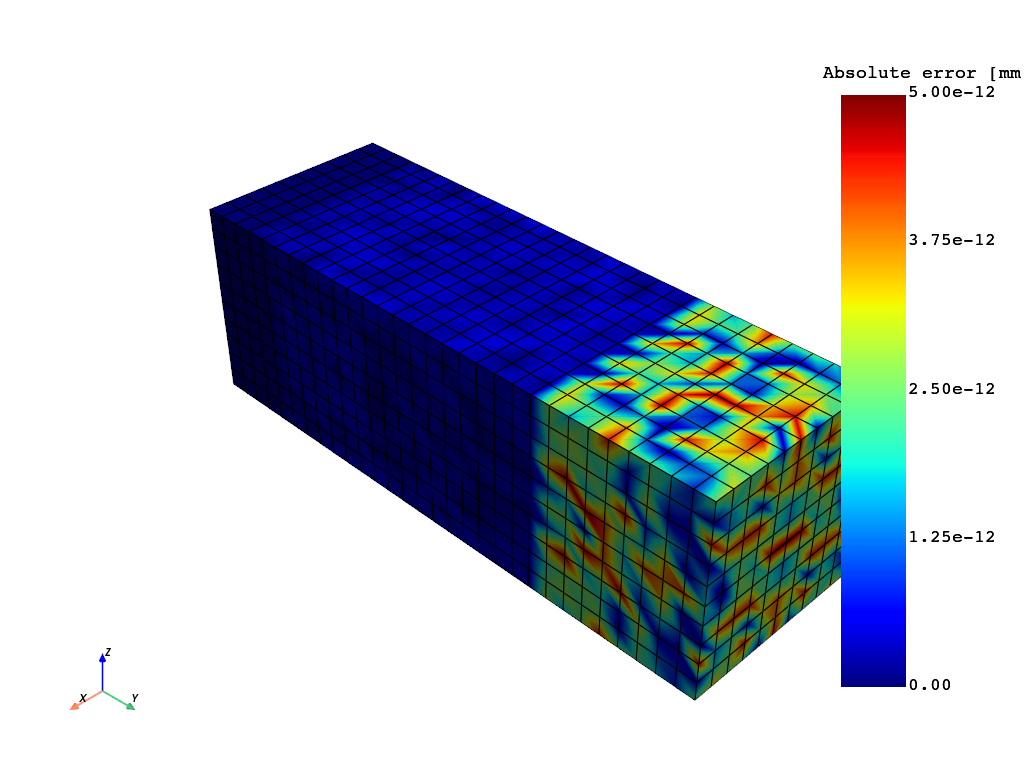

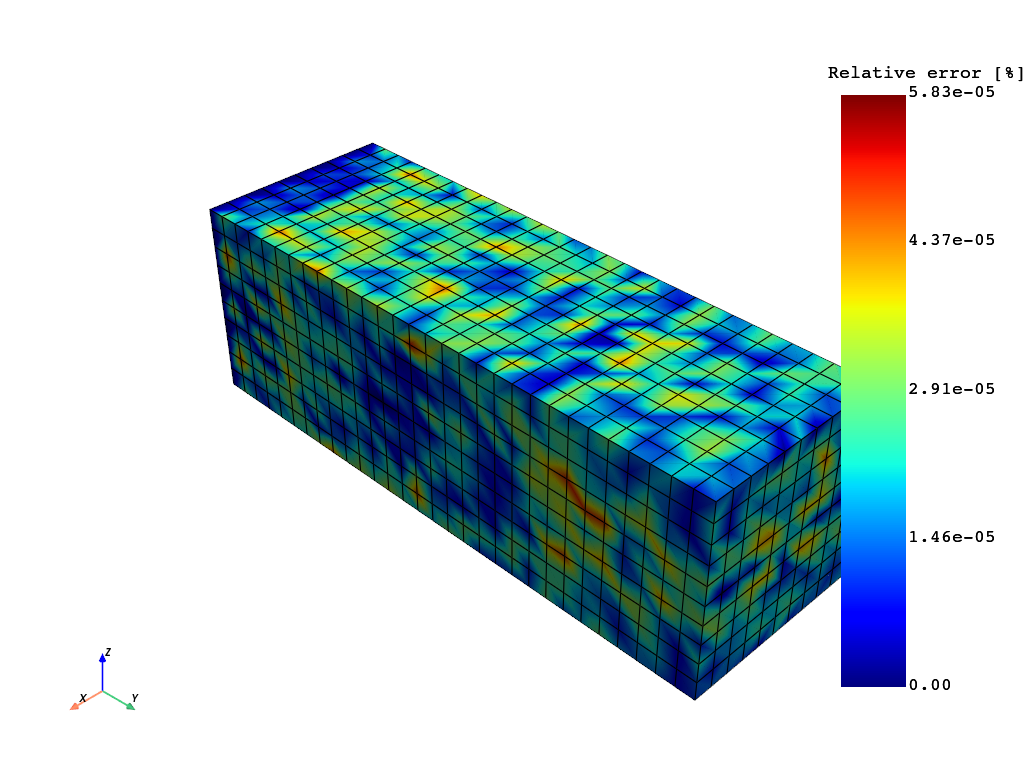

In [8]:
mesh.plot(abs_error, scalar_bar_args={"title": "Absolute error [mm]"})
mesh.plot(rel_error, scalar_bar_args={"title": "Relative error [%]"})